In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from urllib.parse import quote_plus

user = "root"
password = quote_plus("Yangsijie0819$")  # 避免密码里有 @ : / 等特殊字符导致连接串坏掉
host = "127.0.0.1"
port = 3306
db = "aidev"

engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8mb4",
    pool_pre_ping=True,
)

# 2) 读取 RQ3 数据集（只含早期可见特征 + 标签）
df = pd.read_sql("""
SELECT pr_id, repo_id, agent, scenario_label, state, high_cost
FROM pr_rq3_dataset;
""", engine)

# 3) 基本清理
df = df.dropna(subset=["repo_id", "agent", "scenario_label", "state", "high_cost"]).copy()
df["high_cost"] = df["high_cost"].astype(int)

X = df[["agent", "scenario_label", "state"]]
y = df["high_cost"]
groups = df["repo_id"]

# 4) 按 repo 分组切分（更公平）
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# 5) One-hot + Logistic Regression
cat_cols = ["agent", "scenario_label", "state"]
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

clf = LogisticRegression(max_iter=2000, class_weight="balanced")

model = Pipeline(steps=[("preprocess", preprocess), ("clf", clf)])
model.fit(X_train, y_train)

# 6) 评估
proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba)
f1 = f1_score(y_test, pred)
cm = confusion_matrix(y_test, pred)

print("Test AUC:", round(auc, 4))
print("Test F1:", round(f1, 4))
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))

# 7) 输出最重要特征（可写进论文）
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(cat_cols)
coefs = model.named_steps["clf"].coef_[0]

imp = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .assign(abs_coef=lambda d: d["coef"].abs())
    .sort_values("abs_coef", ascending=False)
    .head(20)
)

print("\nTop 20 features by |coef|:\n", imp.to_string(index=False))



Test AUC: 0.831
Test F1: 0.6793
Confusion matrix:
 [[11184   575]
 [  308   935]]

Classification report:
               precision    recall  f1-score   support

           0     0.9732    0.9511    0.9620     11759
           1     0.6192    0.7522    0.6793      1243

    accuracy                         0.9321     13002
   macro avg     0.7962    0.8517    0.8206     13002
weighted avg     0.9394    0.9321    0.9350     13002


Top 20 features by |coef|:
                          feature      coef  abs_coef
    scenario_label_S0_Solo_agent -1.822993  1.822993
              agent_OpenAI_Codex -1.375133  1.375133
scenario_label_S2_Human_coedited  1.045519  1.045519
scenario_label_S1_Human_reviewed  0.915201  0.915201
                     agent_Devin  0.619821  0.619821
                    agent_Cursor  0.601967  0.601967
                   agent_Copilot  0.562015  0.562015
               agent_Claude_Code -0.270942  0.270942
                      state_open  0.235485  0.235485
       

In [3]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba)

# 找到一个让 recall >= 0.85 的最小阈值（高召回预警）
target_recall = 0.85
idx = np.where(recall >= target_recall)[0]
if len(idx) > 0:
    best_i = idx[-1]  # recall 高的点阈值通常更低；这里取最后一个满足的点
    th = thresholds[max(best_i - 1, 0)]
    print("Threshold for recall>=0.85:", th)
else:
    print("No threshold reaches target recall")

# 也可以找 precision>=0.75 的阈值（高精度预警）
target_precision = 0.75
idx2 = np.where(precision >= target_precision)[0]
if len(idx2) > 0:
    best_j = idx2[0]
    th2 = thresholds[max(best_j - 1, 0)]
    print("Threshold for precision>=0.75:", th2)
else:
    print("No threshold reaches target precision")


Threshold for recall>=0.85: 0.39753580791039606
Threshold for precision>=0.75: 0.8646716501911565


AP (Average Precision): 0.5724
Threshold for recall >= 0.85: 0.4291242026181846
Threshold for precision >= 0.75: 0.8692788970339973


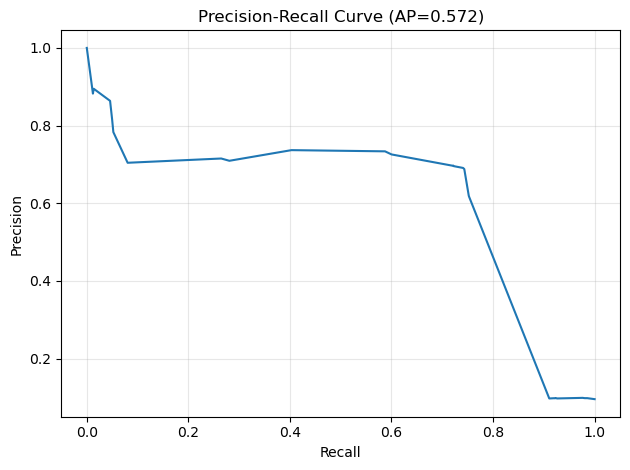

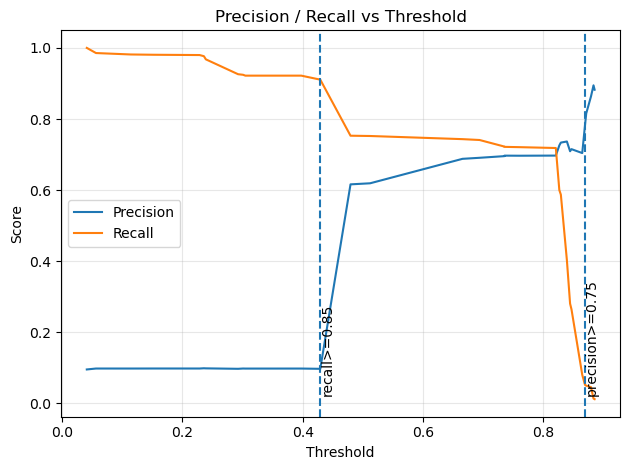

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- 计算 PR 曲线 ---
precision, recall, thresholds = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

# 注意：thresholds 的长度比 precision/recall 少 1
# 为了画 “Precision/Recall vs Threshold”，我们对齐到 thresholds 对应的点：
precision_t = precision[:-1]
recall_t = recall[:-1]
thr = thresholds

# --- 你可以选一个“预警策略”并自动找阈值 ---
# A) 高召回（尽量不漏 high_cost）
target_recall = 0.85
idx_r = np.where(recall_t >= target_recall)[0]
th_recall = thr[idx_r[-1]] if len(idx_r) > 0 else None

# B) 高精度（尽量少误报）
target_precision = 0.75
idx_p = np.where(precision_t >= target_precision)[0]
th_precision = thr[idx_p[0]] if len(idx_p) > 0 else None

print("AP (Average Precision):", round(ap, 4))
print("Threshold for recall >= 0.85:", th_recall)
print("Threshold for precision >= 0.75:", th_precision)

# ========== 图 1：PR 曲线 ==========
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP={ap:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ========== 图 2：Precision/Recall vs Threshold ==========
plt.figure()
plt.plot(thr, precision_t, label="Precision")
plt.plot(thr, recall_t, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall vs Threshold")
plt.grid(True, alpha=0.3)

# 标注推荐阈值（如果存在）
if th_recall is not None:
    plt.axvline(th_recall, linestyle="--")
    plt.text(th_recall, 0.02, "recall>=0.85", rotation=90, va="bottom")
if th_precision is not None:
    plt.axvline(th_precision, linestyle="--")
    plt.text(th_precision, 0.02, "precision>=0.75", rotation=90, va="bottom")

plt.legend()
plt.tight_layout()
plt.show()


In [6]:
print("q0.2:", np.quantile(proba, 0.2))
print("q0.8:", np.quantile(proba, 0.8))
print("rate>=q0.8:", (proba >= np.quantile(proba, 0.8)).mean())


q0.2: 0.4291242026181846
q0.8: 0.4291242026181846
rate>=q0.8: 0.89386248269497


In [7]:
prid_test = df.iloc[test_idx]["pr_id"].to_numpy()


In [9]:
# 按 Top-K 评估

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def eval_topk(alert_rate: float, proba, y_test, prid_test):
    n = len(proba)
    k = int(np.ceil(alert_rate * n))

    # 可复现排序：proba 高优先；并列用 pr_id 小的优先
    order = np.lexsort((prid_test, -proba))
    pred_k = np.zeros(n, dtype=int)
    pred_k[order[:k]] = 1

    out = {
        "alert_rate": alert_rate,
        "k": k,
        "predicted_positive_rate": pred_k.mean(),
        "AUC": roc_auc_score(y_test, proba),
        "precision": precision_score(y_test, pred_k, zero_division=0),
        "recall": recall_score(y_test, pred_k, zero_division=0),
        "f1": f1_score(y_test, pred_k, zero_division=0),
    }
    return out

for ar in [0.10, 0.20]:  # 想加 0.05 就改成 [0.05, 0.10, 0.20]
    out = eval_topk(ar, proba, y_test, prid_test)
    print(
        f"Top-{int(ar*100)}% | k={out['k']} | pos_rate={out['predicted_positive_rate']:.4f} | "
        f"AUC={out['AUC']:.3f} | P={out['precision']:.4f} | R={out['recall']:.4f} | F1={out['f1']:.4f}"
    )



Top-10% | k=1301 | pos_rate=0.1001 | AUC=0.831 | P=0.6941 | R=0.7265 | F1=0.7099
Top-20% | k=2601 | pos_rate=0.2000 | AUC=0.831 | P=0.4087 | R=0.8552 | F1=0.5531
